In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy import stats
import time

# set seaborn settings
sns.set()
plt.rcParams["patch.force_edgecolor"] = True # set lines
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

## import custom helper functions
import helpers as h

In [2]:
fallDf = pd.read_csv("data/2016/fall.csv")
winterDf = pd.read_csv("data/2016/winter.csv")
springDf = pd.read_csv("data/2016/spring.csv")
summerDf = pd.read_csv("data/2016/summer.csv")

In [3]:
# i don't wanna work on the entire dataset. 
# taking a fraction only.

fallFrac = fallDf.sample(frac = 0.01)
winterFrac = winterDf.sample(frac = 0.01)
springFrac = springDf.sample(frac = 0.01)
summerFrac = summerDf.sample(frac = 0.01)

In [4]:
fall = h.convertDataType(fallFrac)
winter = h.convertDataType(winterFrac)
spring = h.convertDataType(springFrac)
summer = h.convertDataType(summerFrac)

In [76]:
fall["season"] = "Fall"
winter["season"] = "Winter"
spring["season"] = "Spring"
summer["season"] = "Summer"


all = pd.DataFrame()
all = pd.concat([fall, winter, spring, summer])
print(len(all))

198783


Now I have sampled version of each seasons. I'd like to look through the earnings of each company throughout each season to see who earns more. For the sake of simplicity, I'll just look at the "trip_total" column for comparison. 

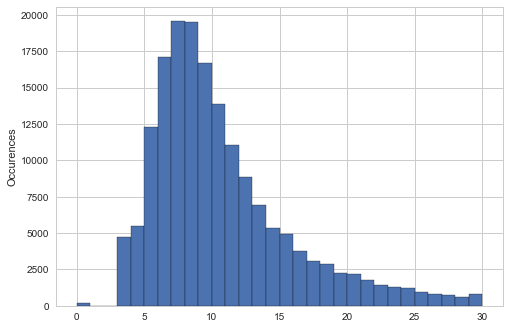

In [64]:
h.buildHistogram(all["trip_total"])

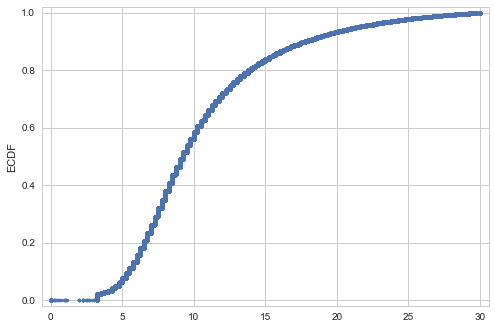

In [65]:
h.buildECDF(all["trip_total"])

In [67]:
all["trip_total"].describe()

count    198783.000000
mean         16.677611
std          37.121610
min           0.000000
25%           7.500000
50%          10.050000
75%          16.500000
max        7751.600000
Name: trip_total, dtype: float64

## Comparing seasonal earnings

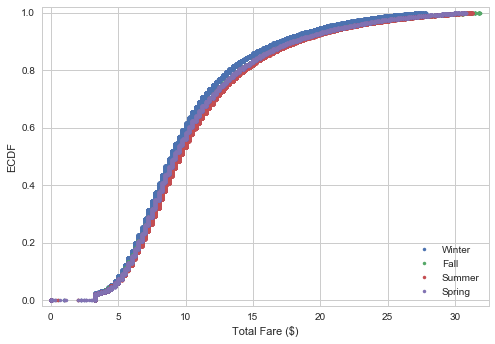

In [68]:
# Generate CDFs
x_winter, y_winter = h.getECDF(winter["trip_total"])
x_fall, y_fall = h.getECDF(fall["trip_total"])
x_summer, y_summer = h.getECDF(summer["trip_total"])
x_spring, y_spring = h.getECDF(spring["trip_total"])

# plot CDFs
_ = plt.plot(x_winter, y_winter, marker = ".", linestyle = "none")
_ = plt.plot(x_fall, y_fall, marker = ".", linestyle = "none")
_ = plt.plot(x_summer, y_summer, marker = ".", linestyle = "none")
_ = plt.plot(x_spring, y_spring, marker = ".", linestyle = "none")

# Make 2% margin
plt.margins(0.02)

# Make a legend and show the plot
_ = plt.legend(('Winter', 'Fall', 'Summer', 'Spring'), loc='lower right')

_ = plt.xlabel("Total Fare ($)")
_ = plt.ylabel("ECDF")
plt.show()

It's bit hard to tell but Summer might yield better earnings than Winter. One possible reason is that people might be more open to going out to events during the Summer than Winter. Let's take a better look.

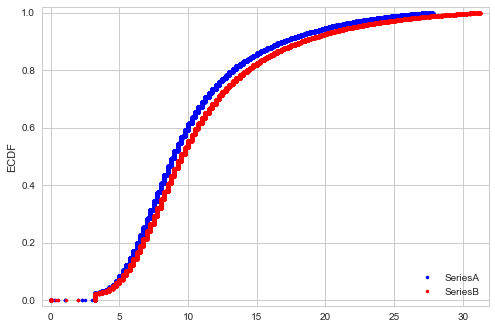

In [69]:
# compare summer and winter earnings
h.compareCDF(winter["trip_total"], summer["trip_total"])

Let's test out this hypothesis. 

* H0 = There is no difference between Summer and Winter earnings.
* H1 = There is a difference between Summer and Winter earnings. 

In [70]:
winterEarnings = np.array(winter["trip_total"])
summerEarnings = np.array(summer["trip_total"])
springEarnings = np.array(spring["trip_total"])
fallEarnings = np.array(fall["trip_total"])

Are the earnings for the 2 seasons different? If they are identical, they should have the same mean earnings so the difference in the mean earnings should be zero. We'll choose the difference in mean as our test statistic. The P-Value tells you that the percentage of chance that you would get the difference of means observed in the experiment if the earnings yields are exactly the same. 

In [71]:
h.identicalMeans(summerEarnings, winterEarnings, 10000)

Empirical Difference in Means: 1.13176991825
P-Value: 0.0


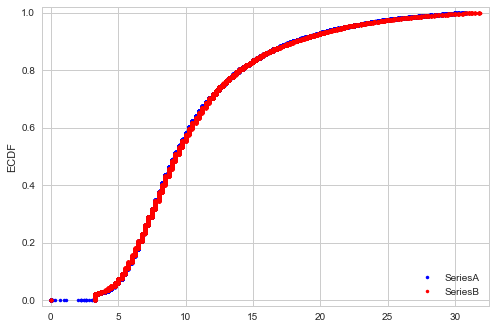

In [72]:
# compare summer and winter earnings
h.compareCDF(spring["trip_total"], fall["trip_total"])

In [73]:
h.identicalMeans(fallEarnings, springEarnings, 10000)

Empirical Difference in Means: 0.664814105618
P-Value: 0.0072


What about Fall and Summer?

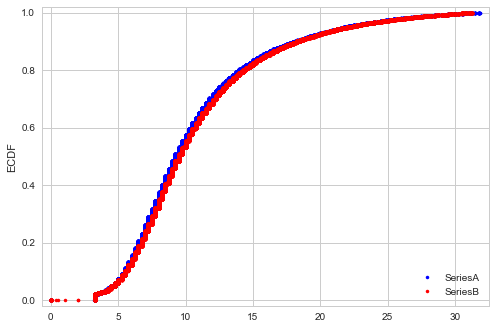

In [74]:
h.compareCDF(fall["trip_total"], summer["trip_total"])

In [75]:
h.identicalMeans(fallEarnings, summerEarnings, 10000)

Empirical Difference in Means: 0.398736007006
P-Value: 0.1138


## Comparing taxi companies

In [81]:
# drop trip records that do not have company name
interestedTrips = all

#interestedTrips = all.dropna(subset = ["company"])

taxiCompanies = set(np.array(interestedTrips["company"]))
taxiCompanies = list(taxiCompanies)
print(taxiCompanies)

[nan, '2241 - 44667 - Felman Corp, Manuel Alonso', '3623 - 72222 Arrington Enterprises', '4053 - 40193 Adwar H. Nikola', '3556 - 36214 RC Andrews Cab', '3669 - 85800 Jordan Taxi Inc', '1085 - 72312 N and W Cab Co', '4623 - 27290 Jay Kim', '1247 - 72807 Daniel Ayertey', '3591 - 63480 Chuks Cab', 'Top Cab Affiliation', '6574 - Babylon Express Inc.', 'Northwest Management LLC', '3201 - C&D Cab Co Inc', '5997 - 65283 AW Services Inc.', '3620 - 52292 David K. Cab Corp.', '5874 - 73628 Sergey Cab Corp.', '3011 - 66308 JBL Cab Inc.', '4615 - 83503 Tyrone Henderson', 'KOAM Taxi Association', '3152 - 97284 Crystal Abernathy', '4787 - 56058 Reny Cab Co', '5062 - 34841 Sam Mestas', 'Patriot Trans Inc', '6743 - 78771 Luhak Corp', '2823 - 73307 Lee Express Inc', '3094 - 24059 G.L.B. Cab Co', '5074 - 54002 Ahzmi Inc', '2192 - 73487 Zeymane Corp', '5724 - 75306 KYVI Cab Inc', 'Suburban Dispatch LLC', '2823 - 73307 Seung Lee', '5129 - 87128', '6057 - 24657 Richard Addo', 'Choice Taxi Association', '31

In [116]:
meanEarnings = interestedTrips.groupby(["company"])["trip_total"] \
    .agg(["mean", "count"]).sort_values("mean", ascending = False).reset_index()

# We only care about Taxi companies that make at least 100 trips in 2016
meanEarnings = meanEarnings[meanEarnings["count"] >= 100].reset_index(drop = True)

In [117]:
meanEarnings

company       mean  count
0                      Suburban Dispatch LLC  26.253004   1265
1   Chicago Elite Cab Corp. (Chicago Carriag  21.543827   9211
2                      T.A.S. - Payment Only  19.818743    517
3                    Choice Taxi Association  17.695265  11283
4                      KOAM Taxi Association  17.159026   3325
5                        Top Cab Affiliation  16.483774   2994
6                  Dispatch Taxi Affiliation  16.375370  17490
7                  Taxi Affiliation Services  15.984347  52966
8          Blue Ribbon Taxi Association Inc.  15.734694  14000
9                   Northwest Management LLC  15.108706   5370
10             Chicago Medallion Leasing INC  14.700432   2174
11              Chicago Medallion Management  13.888555    713

Is there a real difference between first place and last place? If so, is it due to the difference in tips, fare, miles, duration?

In [129]:
first = meanEarnings.head(1)["company"].iloc[0]
print("First:", first)

last = meanEarnings.tail(1)["company"].iloc[0]
print("Last:", last)

First: Suburban Dispatch LLC
Last: Chicago Medallion Management


In [130]:
firstDf = all[all["company"] == first]
lastDf = all[all["company"] == last]

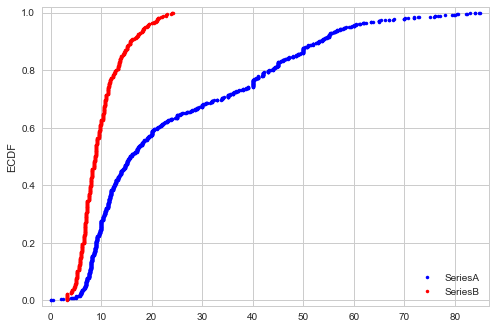

In [133]:
h.compareCDF(firstDf["trip_total"], lastDf["trip_total"])

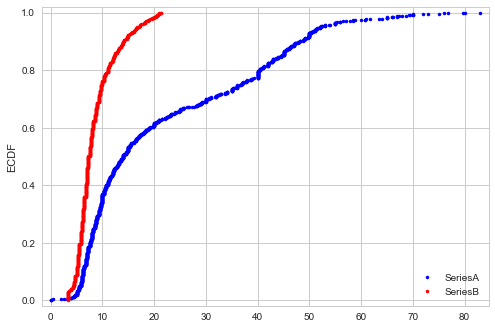

In [135]:
h.compareCDF(firstDf["fare"], lastDf["fare"])

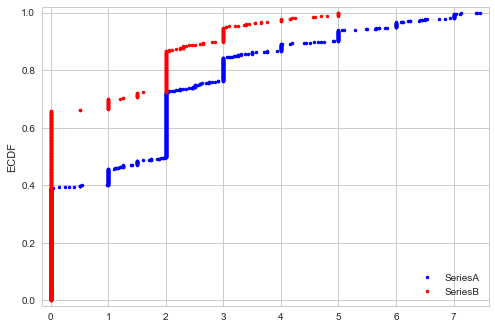

In [146]:
h.compareCDF(firstDf["tips"], lastDf["tips"])

In [148]:
h.identicalMeans(firstDf["fare"], lastDf["fare"], 10000)

Empirical Difference in Means: 12.185565217391304
P-Value: 0.0


Difference in pickup/dropoff locations?